In [1]:
import os
import numpy as np
import pandas as pd
from os.path import join as pjoin
from scipy.stats.stats import sem, zscore
from matplotlib import pyplot as plt
from cxy_visual_dev.lib.predefine import dataset_name2info, proj_dir

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/plot_age_line')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# plot same column of CSV files in one axis

In [2]:
def plot_same_cols_in_one_ax(fpaths, age_name, columns, n_row, n_col, yerr_flag=True, zscore_flag=False, info_file=None,
                             ylabel=None, title='col_name', labels=None, figsize=None, remove_ages=[],
                             out_file=None):
    """
    把多个文件中同名的column画到同一个axis里，不同名的column画到不同axis里

    Args:
        fpaths (str | strings):
            不同文件的行要统一
        age_name (str): column name of age
        columns (str | strings): 指定要画的列
            'all': all columns of fpaths[0]
            len(columns) <= n_row * n_col
        n_row (int): axes的行数
        n_col (int): axes的列数
        yerr_flag (bool, optional): Defaults to True
            True: 显示errorbar
        zscore_flag (bool, optional): Defaults to False.
            True: 在画线之前进行zscore（对某个模态的所有被试做，而不是某个年龄内部做）
        info_file (str, optional): Defaults to None.
            如果提供这个文件，则在该文件中找age信息
            不然就从fpaths[0]里找
        ylabel (str, optional): Defaults to None.
        title (str, optional): Defaults to 'col_name'.
            None: 不显示标题
            'col_name': 以对应的列名做为每个axis的标题
            其它字符串：在第一行中间的axis上显示该字符串为标题
        labels (strings, optional): Defaults to None.
            和文件一一对应，标记对应曲线的label。
        figsize (tuple, optional): Defaults to None.
        remove_ages (integers, optional): Defaults to [].
            去掉这些年龄
        out_file (str, optional): Defaults to None.
            None: 只画不存
    """
    if isinstance(fpaths, str):
        fpaths = [fpaths]
    n_file = len(fpaths)
    dfs = [pd.read_csv(i) for i in fpaths]
    if info_file is None:
        ages = np.array(dfs[0][age_name])
    else:
        info_df = pd.read_csv(info_file)
        ages = np.array(info_df[age_name])
    age_uniq = np.unique(ages).astype(int).tolist()
    for i in remove_ages:
        age_uniq.remove(i)
    n_age = len(age_uniq)

    if columns == 'all':
        columns = dfs[0].columns.to_list()
    elif isinstance(columns, str):
        columns = [columns]
    n_column = len(columns)
    assert n_column <= n_row * n_col

    if labels is None:
        labels = [None] * n_file
    elif isinstance(labels, str):
        labels = [labels] * n_file
    else:
        assert len(labels) == n_file

    _, axes = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1:
        axes = np.array([[axes]])
    elif axes.shape != (n_row, n_col):
        axes = axes.reshape((n_row, n_col))
    max_row_idx = int((n_column-1) / n_col)
    for column_idx, col in enumerate(columns):
        row_idx = int(column_idx / n_col)
        col_idx = column_idx % n_col
        ax = axes[row_idx, col_idx]
        for f_idx, df in enumerate(dfs):
            meas_vec = np.array(df[col])
            non_nan_vec = ~np.isnan(meas_vec)
            meas_vec = meas_vec[non_nan_vec]
            if zscore_flag:
                meas_vec = zscore(meas_vec)
            ages_tmp = ages[non_nan_vec]
            y = np.zeros(n_age, np.float64)
            yerr = np.zeros(n_age, np.float64)
            for age_idx, age in enumerate(age_uniq):
                meas_tmp = meas_vec[ages_tmp == age]
                n_meas = len(meas_tmp)
                if n_meas in (0, 1):
                    raise ValueError(f'#{labels[f_idx]}-{age}:', n_meas)
                elif n_meas < 10:
                    print(f'#{labels[f_idx]}-{age}:', n_meas)
                y[age_idx] = np.mean(meas_tmp)
                yerr[age_idx] = sem(meas_tmp)
            if yerr_flag:
                ax.errorbar(age_uniq, y, yerr, label=labels[f_idx])
            else:
                ax.errorbar(age_uniq, y, label=labels[f_idx])
        if labels[0] is not None:
            ax.legend()
        if col_idx == 0 and ylabel is not None:
            ax.set_ylabel(ylabel)
        if row_idx == max_row_idx:
            ax.set_xlabel(age_name)
        if title is None:
            pass
        elif title == 'col_name':
            ax.set_title(col)
        else:
            if row_idx == 0 and col_idx == int(n_col/2):
                ax.set_title(title)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if out_file is None:
        plt.show()
    else:
        plt.savefig(out_file)

score_C1
#None-6: 5
#None-7: 5
score_C2
#None-6: 5
#None-7: 5


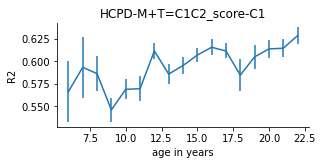

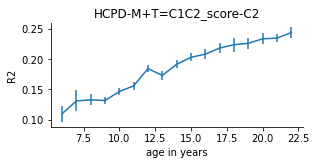

In [3]:
fname = 'HCPD-M+T=C1C2'
cols = ['score_C1', 'score_C2']
for col in cols:
    print(col)
    item, trg_name = col.split('_')
    plot_same_cols_in_one_ax(
        fpaths=pjoin(anal_dir, f'fit/{fname}.csv'),
        age_name='age in years', columns=col, n_row=1, n_col=1, yerr_flag=True, zscore_flag=False,
        info_file=dataset_name2info['HCPD'], title=f'{fname}_{item}-{trg_name}',
        labels=None, figsize=(4.5, 2.4), remove_ages=[], ylabel='R2',
        out_file=pjoin(work_dir, f'{fname}_{item}-{trg_name}.jpg')
        # out_file=None
    )

# plot_cols_in_one_ax

In [4]:
def plot_cols_in_one_ax(fpath, age_name, column_groups, n_row, n_col, yerr_flag=True, zscore_flag=False, info_file=None,
                        ylabel=None, title=None, labels='col_name', figsize=None, remove_ages=[],
                        out_file=None):
    """
    把一个文件中多个column画到同一个axis里，多组column画到不同axis里

    Args:
        fpath (str): CSV file
        age_name (str): column name of age
        column_groups (str | list): 指定要画的列
            'all': 文件中所有column做为1组，画到同一个ax上
            ['all']: 文件中所有column各自成组，分别画到不同ax上
            string: 单列成1组，画到一个ax上
            list：各元素自成1组，设列表元素数量为N，则成N组。画到N个ax上
            组的数量 <= n_row * n_col
        n_row (int): axes的行数
        n_col (int): axes的列数
        yerr_flag (bool, optional): Defaults to True
            True: 显示errorbar
        zscore_flag (bool, optional): Defaults to False.
            True: 在画线之前进行zscore（对某个模态的所有被试做，而不是某个年龄内部做）
        info_file (str, optional): Defaults to None.
            如果提供这个文件，则在该文件中找age信息
            不然就从fpath里找
        ylabel (str, optional): Defaults to None.
        title (str | strings, optional): Defaults to 'col_name'.
            None: 不显示标题
            string：在第一行中间的axis上显示该字符串为标题
            strings: 数量和列的组数一致，分别在各ax上显示标题
        labels (strings, optional): Defaults to None.
            None: 不显示图例
            'col_name': 以列名显示
            strings: 和column_groups一一对应
        figsize (tuple, optional): Defaults to None.
        remove_ages (integers, optional): Defaults to [].
            去掉这些年龄
        out_file (str, optional): Defaults to None.
            None: 只画不存
    """
    df = pd.read_csv(fpath)
    if info_file is None:
        ages = np.array(df[age_name])
    else:
        info_df = pd.read_csv(info_file)
        ages = np.array(info_df[age_name])
    age_uniq = np.unique(ages).astype(int).tolist()
    for i in remove_ages:
        age_uniq.remove(i)
    n_age = len(age_uniq)

    if column_groups == 'all':
        column_groups = [df.columns.to_list()]
    elif column_groups == ['all']:
        column_groups = [[i] for i in df.columns]
    elif isinstance(column_groups, str):
        column_groups = [[column_groups]]
    elif isinstance(column_groups, list):
        for i, e in enumerate(column_groups):
            if isinstance(e, str):
                column_groups[i] = [e]
            elif isinstance(e, list):
                pass
            else:
                raise TypeError('element must be list or str')
    else:
        raise ValueError('not supported column_groups')
    n_group = len(column_groups)
    n_columns = [len(i) for i in column_groups]
    assert n_group <= n_row * n_col

    if labels is None:
        labels = [[None] * i for i in n_columns]
    elif labels == 'col_name':
        labels = column_groups
    else:
        assert isinstance(labels, list)
        assert np.all([isinstance(i, list) for i in labels])
        assert [len(i) for i in labels] == n_columns

    _, axes = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1:
        axes = np.array([[axes]])
    elif axes.shape != (n_row, n_col):
        axes = axes.reshape((n_row, n_col))
    max_row_idx = int((n_group-1) / n_col)
    for group_idx, group in enumerate(column_groups):
        row_idx = int(group_idx / n_col)
        col_idx = group_idx % n_col
        ax = axes[row_idx, col_idx]
        for column_idx, column in enumerate(group):
            label = labels[group_idx][column_idx]
            meas_vec = np.array(df[column])
            non_nan_vec = ~np.isnan(meas_vec)
            meas_vec = meas_vec[non_nan_vec]
            if zscore_flag:
                meas_vec = zscore(meas_vec)
            ages_tmp = ages[non_nan_vec]
            y = np.zeros(n_age, np.float64)
            yerr = np.zeros(n_age, np.float64)
            for age_idx, age in enumerate(age_uniq):
                meas_tmp = meas_vec[ages_tmp == age]
                n_meas = len(meas_tmp)
                if n_meas in (0, 1):
                    raise ValueError(f'#{label}-{age}:', n_meas)
                elif n_meas < 10:
                    print(f'#{label}-{age}:', n_meas)
                y[age_idx] = np.mean(meas_tmp)
                yerr[age_idx] = sem(meas_tmp)
            if yerr_flag:
                ax.errorbar(age_uniq, y, yerr, label=label)
            else:
                ax.errorbar(age_uniq, y, label=label)

        if labels[group_idx][0] is not None:
            ax.legend()

        if col_idx == 0 and ylabel is not None:
            ax.set_ylabel(ylabel)
        if row_idx == max_row_idx:
            ax.set_xlabel(age_name)

        if title is None:
            pass
        elif isinstance(title, str):
            if row_idx == 0 and col_idx == int(n_col/2):
                ax.set_title(title)
        else:
            ax.set_title(title[group_idx])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    if out_file is None:
        plt.show()
    else:
        plt.savefig(out_file)

['coef_C1_Myelination', 'coef_C1_Thickness']
#Myelination-6: 5
#Myelination-7: 5
#Thickness-6: 5
#Thickness-7: 5
['coef_C2_Myelination', 'coef_C2_Thickness']
#Myelination-6: 5
#Myelination-7: 5
#Thickness-6: 5
#Thickness-7: 5


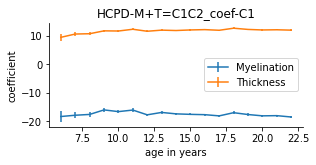

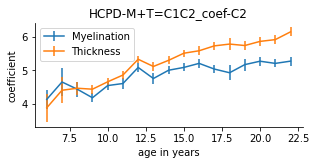

In [6]:
fname = 'HCPD-M+T=C1C2'
cols = [['coef_C1_Myelination', 'coef_C1_Thickness'],
        ['coef_C2_Myelination', 'coef_C2_Thickness']]
zscore_flag=False
for col in cols:
    print(col)
    item, trg_name, _ = col[0].split('_')
    feat_names = [i.split('_')[-1] for i in col]
    plot_cols_in_one_ax(
        fpath=pjoin(anal_dir, f'fit/{fname}.csv'),
        age_name='age in years', column_groups=[col], n_row=1, n_col=1, yerr_flag=True, zscore_flag=zscore_flag,
        info_file=dataset_name2info['HCPD'], title=f'{fname}_{item}-{trg_name}',
        labels=[feat_names], figsize=(4.5, 2.4), remove_ages=[], ylabel='coefficient',
        out_file=pjoin(work_dir, f'{fname}_{item}-{trg_name}.jpg')
        # out_file=None
    )